Text(0, 0.5, 'Voltage (kV)')

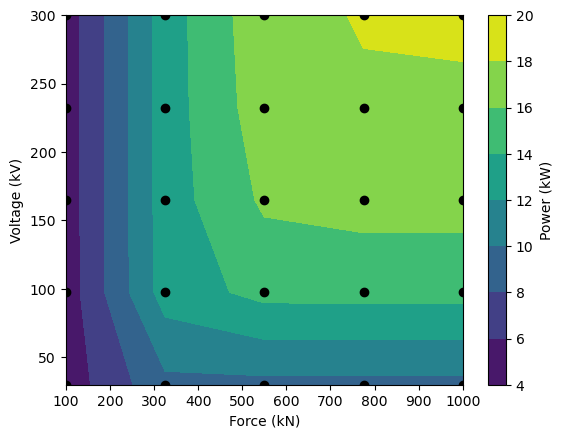

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as interp

# import WecOptTool results csv
df = pd.read_csv('power_sensitivities_2.csv')

# extract the points where position is unconstrained
#max_x = df['x_max'].max()
#df_x_unconstrained = df[df['x_max'] == max_x]
df_x_unconstrained = df
force = df_x_unconstrained['f_max']
voltage = df_x_unconstrained['Vs_max']
power = -df_x_unconstrained['electrical Power']

# reshape to 2D
force_u = force.unique()
voltage_u = voltage.unique()
num_forces = len(force_u)
num_voltages = len(voltage_u)
force = force.values.reshape(num_forces, num_voltages)
voltage = voltage.values.reshape(num_forces, num_voltages)
power = power.values.reshape(num_forces, num_voltages)

# contour plot of power
plt.contourf(force/1000, voltage/1000, power/1000)
plt.colorbar(label='Power (kW)')
plt.scatter(force/1000, voltage/1000, c='k')
plt.xlabel('Force (kN)')
plt.ylabel('Voltage (kV)')


error:
 [[52.77488065 25.73710653 15.45322778 10.36010183  7.53823832]
 [28.95585374 17.74167211  7.05770329  1.45864619 -1.6441121 ]
 [ 8.92513481  6.6388524   4.99093786  3.80611197  2.4674625 ]
 [ 4.08560941  1.68447303  2.68551589  2.63735238  1.467815  ]
 [ 3.29020788  0.86918306  1.87842402  2.0377385   0.98255491]]


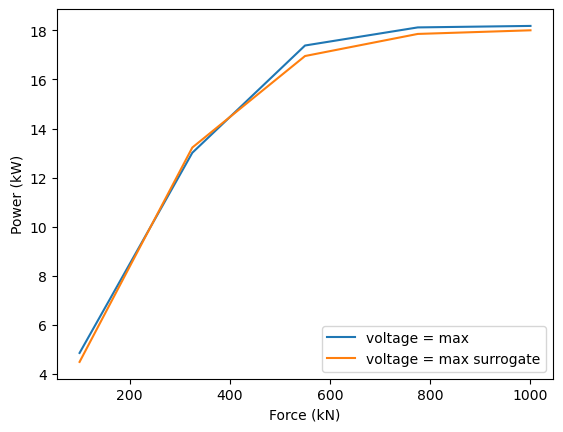

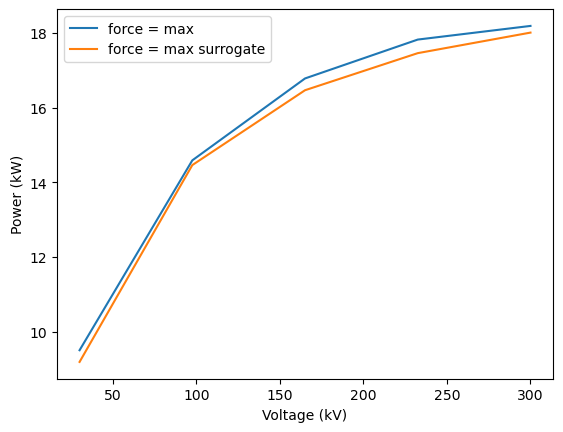

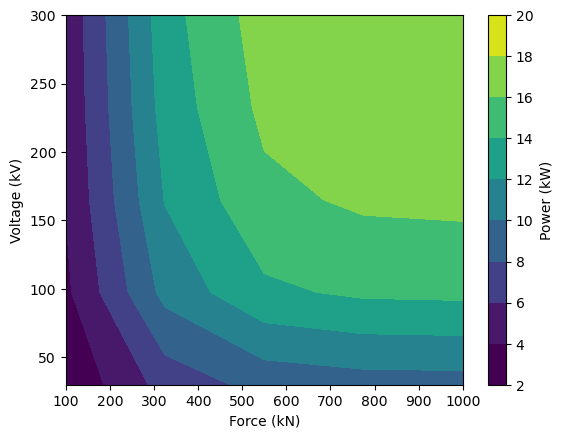

In [17]:

P_max = np.max(power)
force_const = 280e3
voltage_const = 55e3
power_surrogate = P_max * 0.99*(1 - np.exp(-(force/force_const)**1.5)+0.075) * 0.99*(1 - np.exp(-(voltage/voltage_const)**0.65)-0.01)
 
plt.figure()
plt.plot(force_u/1000, power[:, -1]/1000, label='voltage = max')
slope = 0.02
plt.plot(force_u/1000, power_surrogate[:,-1]/1000, label='voltage = max surrogate')
plt.xlabel('Force (kN)')
plt.ylabel('Power (kW)')
plt.legend()

plt.figure()
plt.plot(voltage_u/1000, power[-1, :]/1000, label='force = max')
slope = 0.02
plt.plot(voltage_u/1000, power_surrogate[-1,:]/1000, label='force = max surrogate')
plt.xlabel('Voltage (kV)')
plt.ylabel('Power (kW)')
plt.legend()


plt.figure()
plt.contourf(force/1000, voltage/1000, power_surrogate/1000, vmin=4, vmax=20, levels=[2,4,6,8,10,12,14,16,18,20])
plt.colorbar(label='Power (kW)')
plt.xlabel('Force (kN)')
plt.ylabel('Voltage (kV)')


# convert voltage to effective max speed
# notebook p144
#w_max = voltage / (p * lambda)

percent_error = (power - power_surrogate)/power * 100
#print("power:\n", power, "\nsurrogate power:\n", power_surrogate)
print("\nerror:\n", percent_error)

In [ ]:

# interpolate to get normalized power
force_i = np.linspace(force_u[0], force_u[-1], 10)
voltage_i = np.linspace(voltage_u[0], voltage_u[-1], 10)
force_i, voltage_i = np.meshgrid(force_i, voltage_i)
points = (force_u, voltage_u)
values = power_surrogate
xi = (force_i, voltage_i)
power_interp = interp.interpn(points, values, xi)


In [ ]:

# import joint probability distribution from file
file = 'Humboldt_California_Wave Resource _SAM CSV.csv'
jpd = pd.read_csv(file, skiprows=2, header=None).values
probabilities = jpd[1:, 1:].astype(float),  # joint probability distribution of wave (%)
Hs = jpd[1:, 0].astype(float),  # wave height (m)
Te = jpd[0, 1:].astype(float),  # wave period (s)

# En's sims assumed a wave with wavefreq = 0.3 Hz, amplitude = 1
# scale the normalized power to get power matrix for different sea states
Te_base = 1/0.3
Hs_base = 2
Te, Hs = np.meshgrid(Te, Hs)
power_multiplier = (Hs/Hs_base)**2 * (Te/Te_base)
power_matrix = np.expand_dims(power_interp, axis=(2,3)) * power_multiplier
print(power_matrix.shape) # (num forces interp, num voltages interp, num Hs num Te)
# fixme: the power multiplier should include the fact that there is a different 
# relative force limit, and therefore different power_interp, for each sea state

# plot power matrix for one force/voltage combo
plt.figure()
plt.contourf(Hs, Te, power_matrix[0,0,:,:]/1000)
plt.colorbar(label='Power (kW)')
plt.xlabel('Hs (m)')
plt.ylabel('Te (s)')

# calculate annual energy production
P_weighted = power_matrix * probabilities / 100
P_elec = np.sum(P_weighted, axis=(2,3)) # sum over sea states
hr_per_yr = 8766
aep = P_elec * hr_per_yr / 1000 # kWh

# plot annual energy production for all force/voltage combos
plt.figure()
plt.contourf(force_i/1000, voltage_i/1000, aep/1000)
plt.colorbar(label='AEP (MWh)')
plt.xlabel('Force (kN)')
plt.ylabel('Voltage (kV)')


In [ ]:
# provide a nondimensional torque-speed contour
t = np.linspace(0,2*np.pi)
x = np.sin(t)
xdot = np.cos(t)
a_vals = [0,0.25,0.5,0.75,1,2]

for a in a_vals:
    plt.figure(1)
    T = xdot + a * x
    plt.plot(xdot,T, label=f'a = {a}')

    plt.figure(2)
    T_sat = np.clip(T, -1, 1)
    plt.plot(xdot,T_sat, label=f'a = {a}')

    plt.figure(3)
    base_over_max_speed = 0.4
    T_voltage_y_intercept = 1.5
    base_speed = 0.7
    T_voltage_x_intercept = base_speed / base_over_max_speed
    voltage_slope = -T_voltage_y_intercept / T_voltage_x_intercept
    T_voltage = T_voltage_y_intercept + voltage_slope * np.abs(xdot)
    T_sat_sat = np.clip(T_sat, -T_voltage, T_voltage)
    plt.plot(xdot,T_sat_sat, label=f'a = {a}')

plt.figure(1)
plt.xlabel('speed')
plt.ylabel('torque')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.title('Unsaturated')

plt.figure(2)
plt.xlabel('speed')
plt.ylabel('torque')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.title('Saturated Torque Only')

plt.figure(3)
plt.xlabel('speed')
plt.ylabel('torque')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.title('Saturated Torque and Voltage')

In [ ]:
# torque speed contour for each sea state

# scale the WecOptTool torque by Hs and scale the WecOptTool speed by 1/Te


In [ ]:
# check damping vs frequency from WecOptTool results
rho = 1030
f1 = 0.05
B_df = pd.read_csv('damping_vs_omega.csv')
T = 2*np.pi/B_df['omega']
B = B_df['damping_normalized']*rho*f1*2*np.pi
plt.plot(T, B)
plt.xlabel('Wave period (s)')
plt.ylabel('Radiation Damping (N/(m/s))')

# maximum power assuming perfect impedance matching and 100% efficiency
P_max = F_e**2 / (8*B)
# haskind relationship says B * 4 rho g Vg / k = (F_e/H_s)^2
# in deep water we have Vg = g/(2 w) and k = w^2/g
# so B * 4 rho g Vg / k = B * 4 rho g^2 / (2 w) * g / w^2 = 2 B rho g^3 / w^3
# which means B = w^3 / (2 rho g^3) * (F_e / H_s)^2
# and so P_max = F_e^2 / (8 * w^3 / (2 rho g^3) * (F_e / H_s)^2) = 1/4 * rho g^3 H_s^2 / w^3

# compare against P_wave_per_m = rho g^2 Hs^2  / (32 w)
# CW_max = g/ w^2
# gives P_max = rho g^3 Hs^2 / (32 w^3)
# which is off by a factor of 8 from the above

# if B were too small by a factor of x then F_e would be too small by a factor of sqrt(x)
# and power would change by a factor of sqrt(x)^2/x = 1
# so power wouldn't change, so B being too big/small is not the issue